In [1]:
import json
from collections import defaultdict

import numpy as np
import pandas as pd
from matplotlib import pyplot as plt

In [2]:
PITCH_LENGTH = 120
PITCH_WIDTH = 80
NX, NY = 12, 8  # grid size (columns × rows)
N_ITER = 5  # number of value iteration passes

In [3]:
def get_zone(x, y):
    xi = min(NX - 1, int(x / PITCH_LENGTH * NX))
    yi = min(NY - 1, int(y / PITCH_WIDTH * NY))
    return xi, yi

In [4]:
def build_transition_and_shot_probs_full(events):
    transitions = np.zeros((NX, NY, NX, NY))
    shots_from = np.zeros((NX, NY))
    goals_from = np.zeros((NX, NY))
    counts = np.zeros((NX, NY))

    for _, e in events.iterrows():
        if not isinstance(e.get("location"), list):
            continue
        x, y = e["location"]
        xi, yi = get_zone(x, y)
        counts[xi, yi] += 1
        type_name = e["type"]["name"]

        if type_name == "Pass" and isinstance(e.get("pass").get("end_location"), list):
            xe, ye = e["pass"]["end_location"]
            xj, yj = get_zone(xe, ye)
            transitions[xi, yi, xj, yj] += 1

        elif type_name == "Carry" and isinstance(
            e.get("carry").get("end_location"), list
        ):
            xe, ye = e["carry"]["end_location"]
            xj, yj = get_zone(xe, ye)
            transitions[xi, yi, xj, yj] += 1

        elif type_name == "Shot":
            shots_from[xi, yi] += 1
            xg = e.get("shot").get("statsbomb_xg")
            goals_from[xi, yi] += xg  # expected goals as "soft" goals

    # Normalize to probabilities
    P_shot = np.divide(
        shots_from, counts, out=np.zeros_like(shots_from), where=counts > 0
    )
    P_goal_given_shot = np.divide(
        goals_from, shots_from, out=np.zeros_like(goals_from), where=shots_from > 0
    )
    P_goal = P_shot * P_goal_given_shot

    # Normalize transitions row-wise
    for xi in range(NX):
        for yi in range(NY):
            total = transitions[xi, yi].sum()
            if total > 0:
                transitions[xi, yi] /= total

    return P_goal, P_shot, transitions


def build_transition_and_shot_probs(events):
    transitions = np.zeros((NX, NY, NX, NY), dtype=np.float64)
    shots_from = np.zeros((NX, NY), dtype=np.float64)
    goals_from = np.zeros((NX, NY), dtype=np.float64)
    counts = np.zeros((NX, NY), dtype=np.float64)

    for e in events:
        loc = e.get("location")
        if not isinstance(loc, list) or len(loc) < 2:
            continue
        x, y = loc
        xi, yi = get_zone(x, y)
        counts[xi, yi] += 1
        t = e["type"]

        if t in ("Pass", "Carry"):
            end_loc = e.get("end_location")
            if isinstance(end_loc, list) and len(end_loc) >= 2:
                xe, ye = end_loc
                xj, yj = get_zone(xe, ye)
                transitions[xi, yi, xj, yj] += 1

        elif t == "Shot":
            shots_from[xi, yi] += 1
            goals_from[xi, yi] += e.get("xg", 0.0)

    # Normalize to probabilities
    P_shot = np.divide(
        shots_from, counts, out=np.zeros_like(shots_from), where=counts > 0
    )
    P_goal_given_shot = np.divide(
        goals_from, shots_from, out=np.zeros_like(goals_from), where=shots_from > 0
    )
    P_goal = P_shot * P_goal_given_shot

    # Normalize transitions
    row_sum = transitions.sum(axis=(2, 3), keepdims=True)
    np.divide(transitions, row_sum, out=transitions, where=row_sum > 0)

    return P_goal, P_shot, transitions

In [5]:
def compute_xT(P_goal, P_shot, transitions, n_iter=N_ITER):
    xT = P_goal.copy()
    for _ in range(n_iter):
        new_xT = np.zeros_like(xT)
        for xi in range(NX):
            for yi in range(NY):
                continuation = np.sum(transitions[xi, yi] * xT)
                new_xT[xi, yi] = P_goal[xi, yi] + (1 - P_shot[xi, yi]) * continuation
        xT = new_xT
    return xT

In [6]:
def apply_xT(events, xT):
    player_xT = defaultdict(float)
    for e in events:
        if e["type"] != "Pass":
            continue
        x1, y1 = e["location"]
        x2, y2 = e["end_location"]
        xi, yi = get_zone(x1, y1)
        xj, yj = get_zone(x2, y2)

        delta = xT[xj, yj] - xT[xi, yi]
        if "player.name" in e:
            player_xT[e["player.name"]] += delta
    return player_xT

In [7]:
paths = [
    "../output/England_xt.jsonl",
    "../output/France_xt.jsonl",
    "../output/Germany_xt.jsonl",
    "../output/Italy_xt.jsonl",
    "../output/Spain_xt.jsonl",
]

events = []

for path in paths:
    with open(path, "r", encoding="utf-8") as f:
        for line in f:
            events.append(json.loads(line))

In [8]:
P_goal, P_shot, transitions = build_transition_and_shot_probs(events)

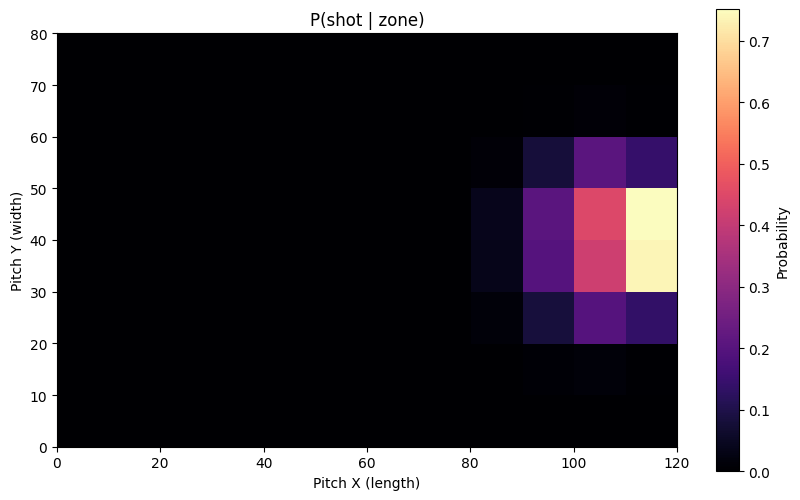

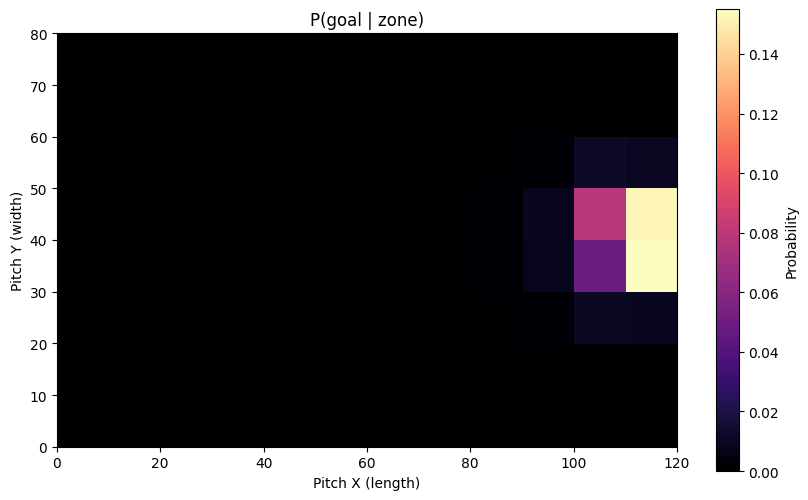

In [9]:
def plot_heatmap(matrix, title):
    plt.figure(figsize=(10, 6))
    plt.imshow(matrix.T, origin="lower", cmap="magma", extent=[0, 120, 0, 80])
    plt.colorbar(label="Probability")
    plt.title(title)
    plt.xlabel("Pitch X (length)")
    plt.ylabel("Pitch Y (width)")
    plt.show()


plot_heatmap(P_shot, "P(shot | zone)")
plot_heatmap(P_goal, "P(goal | zone)")

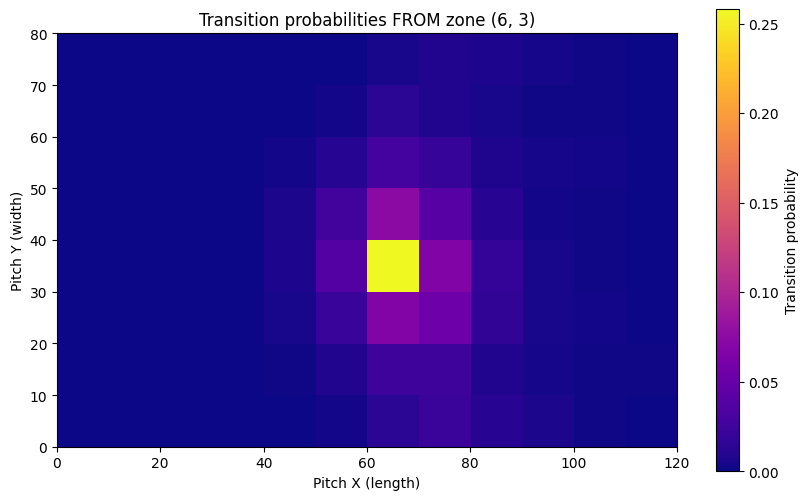

In [10]:
from_zone = (6, 3)
to_matrix = transitions[from_zone[0], from_zone[1]]

plt.figure(figsize=(10, 6))
plt.imshow(to_matrix.T, origin="lower", cmap="plasma", extent=[0, 120, 0, 80])
plt.colorbar(label="Transition probability")
plt.title(f"Transition probabilities FROM zone {from_zone}")
plt.xlabel("Pitch X (length)")
plt.ylabel("Pitch Y (width)")
plt.show()

In [11]:
%matplotlib qt

fig, ax = plt.subplots(figsize=(8, 5))
ax.set_title("Click a zone to view its outgoing transitions")
ax.set_xlabel("Pitch X (length)")
ax.set_ylabel("Pitch Y (width)")

from_zone = (6, 3)
to_matrix = transitions[from_zone[0], from_zone[1]]
im = ax.imshow(to_matrix.T, origin="lower", cmap="plasma", extent=[0, 120, 0, 80])

cbar = fig.colorbar(im, ax=ax, fraction=0.046, pad=0.04)
cbar.set_label("Transition Probability")


# --- Click handler ---
def onclick(event):
    if event.inaxes != ax:
        return
    x, y = event.xdata, event.ydata
    if x is None or y is None:
        return

    # convert field coordinates → grid indices
    xi = int(x / PITCH_LENGTH * NX)
    yi = int(y / PITCH_WIDTH * NY)
    xi = np.clip(xi, 0, NX - 1)
    yi = np.clip(yi, 0, NY - 1)

    # look up correct transition slice
    to_matrix = transitions[xi, yi]

    im.set_data(to_matrix.T)  # transpose for display
    im.autoscale()
    ax.set_title(f"Transitions FROM zone ({xi}, {yi})")
    cbar.update_normal(im)
    plt.draw()


# Connect the click event
fig.canvas.mpl_connect("button_press_event", onclick)

plt.tight_layout()
plt.show()

In [12]:
xT_grid = compute_xT(P_goal, P_shot, transitions)

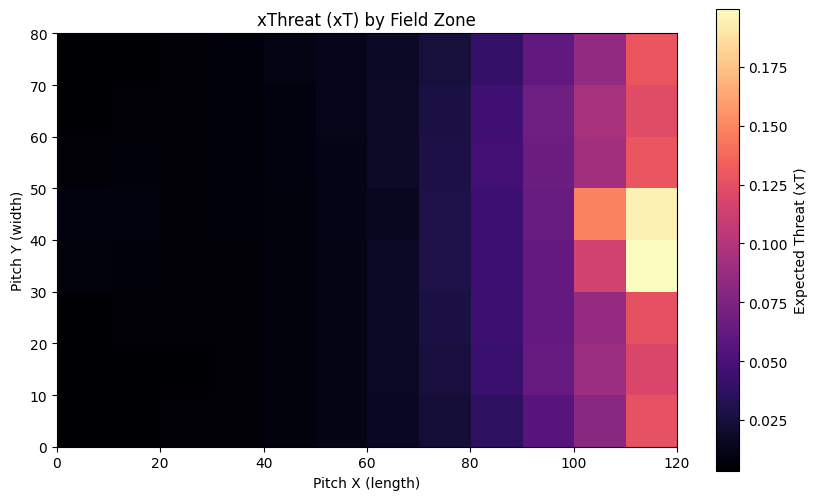

In [13]:
%matplotlib inline

plt.figure(figsize=(10, 6))
plt.imshow(
    xT_grid.T,
    origin="lower",
    cmap="magma",
    extent=[0, PITCH_LENGTH, 0, PITCH_WIDTH],
)
plt.colorbar(label="Expected Threat (xT)")
plt.title("xThreat (xT) by Field Zone")
plt.xlabel("Pitch X (length)")
plt.ylabel("Pitch Y (width)")
plt.show()